In [1]:
#!Pip install numpy
#!Pip install pandas
#!Pip install seaborn
#!Pip install scikit-learn
#!Pip install scipy

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [4]:
# loading data
df = pd.read_csv('sampled_data.csv')
print(df.shape)

(1998, 2)


In [5]:
df.head(3).T

,0,1,2
Haber Gövdesi,"USTA OYUNCU RUTKAY AZİZ, 'ANKARA'NIN NESİ GÜZ...","Aleksandre Kodan'ın, BabbaMedia etiketiyle yay...",Emrah’ın yıllardır küs olduğu oğlu Tayfun evle...
Sınıf,Magazin,Magazin,Magazin


In [6]:
# Create a new dataframe with two columns
df1 = df[['Sınıf', 'Haber Gövdesi']].copy()

print(df1.shape)
df1.head(3).T

(1998, 2)


,0,1,2
Sınıf,Magazin,Magazin,Magazin
Haber Gövdesi,"USTA OYUNCU RUTKAY AZİZ, 'ANKARA'NIN NESİ GÜZ...","Aleksandre Kodan'ın, BabbaMedia etiketiyle yay...",Emrah’ın yıllardır küs olduğu oğlu Tayfun evle...


In [7]:
pd.DataFrame(df1["Sınıf"].unique()).values

array([['Magazin'],
       ['Siyaset'],
       ['Sağlık'],
       ['Spor'],
       ['Turizm'],
       ['Kültür-Sanat'],
       ['Finans-Ekonomi'],
       ['Bilim-Teknoloji'],
       ['Çevre']], dtype=object)

In [8]:

df2 =df1.sample(1998, random_state = 1).copy()
# Creare a new column 'category_id' with encoded categories
df2['category_id'] = df2['Sınıf'].factorize()[0]
category_id_df = df2[['Sınıf','category_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Sınıf']].values)
# New dataframe
df2.head()

,Sınıf,Haber Gövdesi,category_id
608,Sağlık,"Psikolog Didem Cengiz, SANKO Üniversitesi Sani...",0
1697,Bilim-Teknoloji,DUVAR - Dünyaca ünlü bilim insanı ve giyilebil...,1
790,Spor,Fenerbahçe'de 11 oyuncunun sözleşmesi sona er...,2
650,Sağlık,Birçok kişinin ortak sorunu olan saç dökülmesi...,0
1636,Bilim-Teknoloji,Apple öğretmenler için geliştirdiği yeni ücret...,1


In [15]:
df2 = df2.rename(columns={'Haber Gövdesi': 'HaberGovdesi'})

In [16]:
df2.head()

,Sınıf,HaberGovdesi,category_id
608,Sağlık,"Psikolog Didem Cengiz, SANKO Üniversitesi Sani...",0
1697,Bilim-Teknoloji,DUVAR - Dünyaca ünlü bilim insanı ve giyilebil...,1
790,Spor,Fenerbahçe'de 11 oyuncunun sözleşmesi sona er...,2
650,Sağlık,Birçok kişinin ortak sorunu olan saç dökülmesi...,0
1636,Bilim-Teknoloji,Apple öğretmenler için geliştirdiği yeni ücret...,1


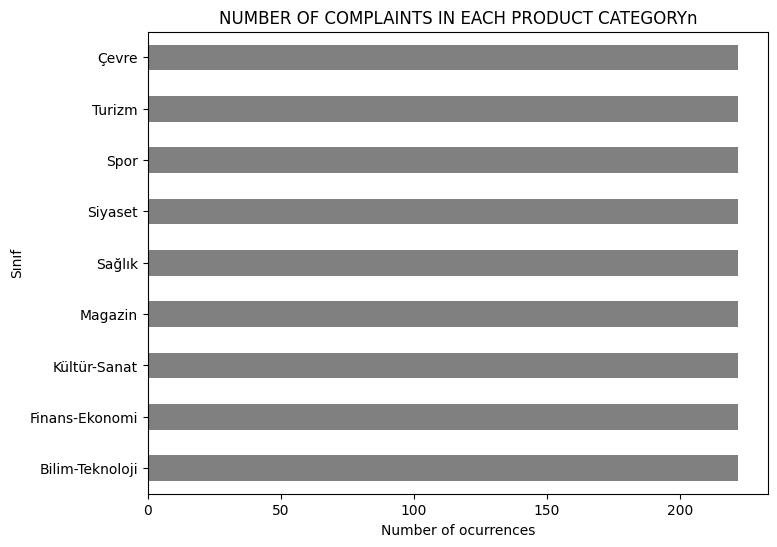

In [17]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Sınıf').HaberGovdesi.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORYn')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Türkçe stop-word listesi
turkish_stopwords = set(stopwords.words('turkish'))

In [23]:
turkish_stopwords = list(stopwords.words('turkish'))

In [24]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words=turkish_stopwords)
# We transform each complaint into a vector
features = tfidf.fit_transform(df2.HaberGovdesi).toarray()
labels = df2.category_id
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1998 complaints is represented by 13928 features (TF-IDF score of unigrams and bigrams)


In [27]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Sınıf, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]  # get_feature_names_out() kullanıldı
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(Sınıf))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> Bilim-Teknoloji:
  * Most Correlated Unigrams are: iphone, akıllı, apple
  * Most Correlated Bigrams are: yorumlar kısmından, yapay zeka, akıllı telefon
n==> Finans-Ekonomi:
  * Most Correlated Unigrams are: bitcoin, kripto, faiz
  * Most Correlated Bigrams are: tarihli işlemlerden, altın fiyatları, 2024 tarihli
n==> Kültür-Sanat:
  * Most Correlated Unigrams are: festivali, sanat, tiyatro
  * Most Correlated Bigrams are: yorum sim, edersiniz duvar, kültür sanat
n==> Magazin:
  * Most Correlated Unigrams are: survivor, şarkıcı, ünlü
  * Most Correlated Bigrams are: güzel oyuncu, instagram hesabından, ünlü şarkıcı
n==> Sağlık:
  * Most Correlated Unigrams are: tedavi, sağlık, dr
  * Most Correlated Bigrams are: uzmanı dr, prof dr, op dr
n==> Siyaset:
  * Most Correlated Unigrams are: kılıçdaroğlu, parti, chp
  * Most Correlated Bigrams are: ak parti, çikan vi, yi parti
n==> Spor:
  * Most Correlated Unigrams are: süper, galatasaray, lig
  * Most Correlated Bigrams are: lig in, tekn

In [30]:
X = df2['HaberGovdesi'] # Collection of documents
y = df2['Sınıf'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [31]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

In [32]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.808306,0.010893
LogisticRegression,0.796787,0.020159
MultinomialNB,0.778274,0.018817
RandomForestClassifier,0.641137,0.016486


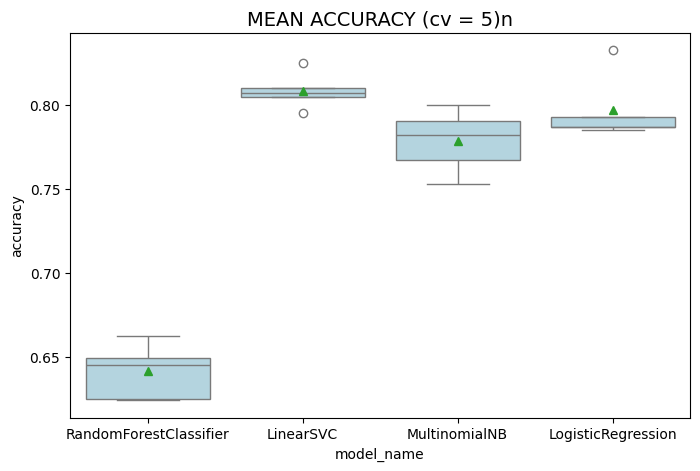

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

In [34]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,labels, df2.index, test_size=0.25,random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [35]:
# Classification report
print('ttttCLASSIFICATIION METRICSn')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Sınıf'].unique()))

ttttCLASSIFICATIION METRICSn
                 precision    recall  f1-score   support

         Sağlık       0.87      0.94      0.90        70
Bilim-Teknoloji       0.85      0.79      0.82        52
           Spor       0.98      0.96      0.97        49
 Finans-Ekonomi       0.81      0.78      0.80        60
         Turizm       0.72      0.82      0.77        44
          Çevre       0.84      0.69      0.76        52
   Kültür-Sanat       0.70      0.80      0.75        54
        Siyaset       0.79      0.74      0.76        61
        Magazin       0.86      0.88      0.87        58

       accuracy                           0.82       500
      macro avg       0.83      0.82      0.82       500
   weighted avg       0.83      0.82      0.82       500



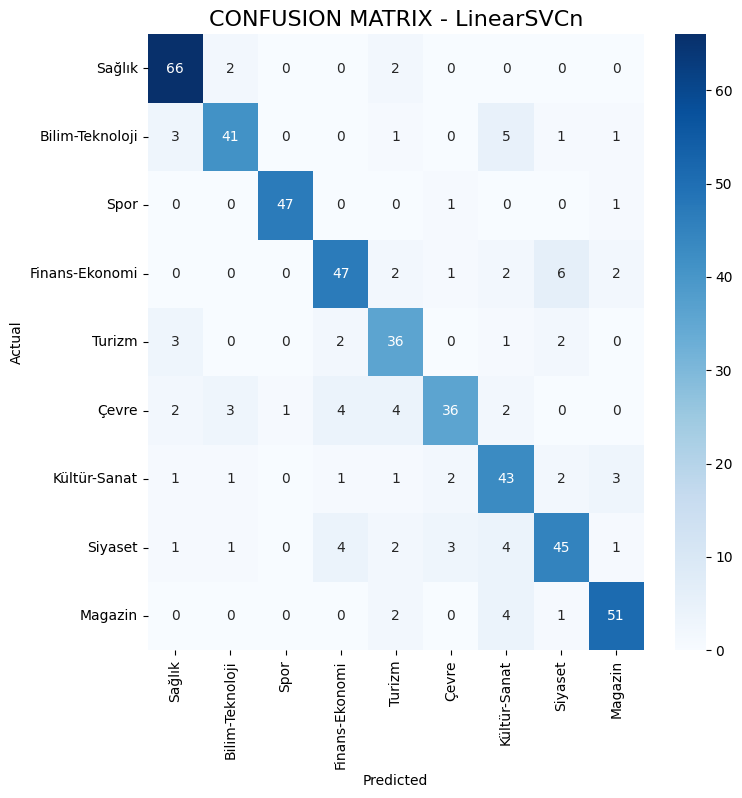

In [37]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Sınıf.values, 
            yticklabels=category_id_df.Sınıf.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words=turkish_stopwords)

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

C:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [40]:
complaint = """Hazine ve Maliye Bakanı Mehmet Şimşek, kayıt dışı ekonomiyle mücadele amacıyla attıkları adımları genişlettiklerini söyledi.

Gelir İdaresi Başkanlığının, işletmelerde kullanılan POS cihazlarından gerçekleştirilen tahsilat tutarlarından oluşan hasılatın beyan edilip edilmediğini gündemine aldığını bildiren Şimşek, bu kapsamda olası vergi kayıp ve kaçağının denetlediğini aktardı.

Şimşek, Başkanlık tarafından 2021 ve 2022 yıllarına ilişkin yapılan analiz çalışmalarından hareketle vergi kayıp ve kaçağına neden olduğu yönünde emareler bulunan işletmeler hakkında denetimlere başlandığına dikkati çekerek, denetim sonuçlarına ilişkin şu bilgileri paylaştı:

"Denetim çalışmalarında, vergi mükellefi olmadığı halde üzerlerine kayıtlı POS cihazları bulunan ve bu cihazlar üzerinden hasılat elde eden 2 bin 320 kişi ele alındı. Bu kişilerin toplamda 3 milyar lira kayıt dışı hasılat elde ettiği ve vergi idaresinin bilgisi dışında bıraktığı belirlendi. Mükellefiyeti olan 1342 kişinin ise yine POS cihazları üzerinden elde ettiği toplamda 2 milyar lira hasılatı beyanlarına yansıtmadığı veya eksik yansıttığı tespit edildi. Böylece Gelir İdaresi Başkanlığımız, POS cihazlarından gerçekleştirdiği tahsilatın hasılat kaydını yapmayan 3 bin 662 kişiyi tespit etti. Bu kişilerin 5 milyar liralık POS hasılatının beyan edilmesi sağlandı."

"1,5 milyar lira vergi tahakkuk ettirildi"
Bu süreçte söz konusu kişilerin vergi daireleri tarafından izaha davet edildiğini belirten Şimşek, "Bu kişilerden 2021 ve 2022 yıllarına ilişkin vergi mükellefiyetlerine göre gelir vergisi, kurumlar vergisi, katma değer vergisi beyannameleri ile muhtasar beyannameleri olmak üzere 18 bin 500 vergi beyannamesi alındı. Kayıt dışı bırakılan yaklaşık 5 milyar liralık POS hasılatının beyan edilmesi de bu şekilde sağlandı" diye konuştu.

Şimşek, bu çalışma sonucunda 1,5 milyar lira vergi tahakkuk ettirildiğine işaret etti.

"Mükellef olmadan POS hasılatı elde ediyorlar"
Denetim çalışmalarında çarpıcı örneklere rastlandığını da anlatan Şimşek, "Denetimlerde vergi mükellefi olmadan 1 milyon liranın üzerinde POS hasılatı elde eden 81 kişi bulundu. Bu mükelleflerin ilgili dönemlerdeki hasılat tutarının yaklaşık 253 milyon lira olduğu görüldü. Bunlar arasında toptan ayakkabı, hırdavat malzemeleri, tekstil ürünleri ve beyaz eşya ticareti başta olmak üzere çeşitli alanlarda faaliyetlerde bulunan kişilerin yer aldığı tespit edildi" ifadesini kullandı.

Bakan Şimşek, benzer çalışmanın 2023 yılı verileri üzerinden de yapıldığını belirtirken, "Elde edilen sonuçlar üzerine gerekli işlemler yapılacak. Kayıt dışı ekonomiyle mücadelemiz tavizsiz ve güçlü şekilde devam edecek" diye konuştu."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Finans-Ekonomi']


In [41]:
complaint = """Nadir görülen bir yüksek tansiyon türü olan "pulmoner hipertansiyon" hastası 60 yaşındaki Aykut İnciler, akciğerinin fonksiyonlarını yerine getirememesi sonucu 3 yıldır çantasında taşıdığı yapay akciğer cihazıyla hayatını sürdürüyor.
Ankara'da yaşayan İnciler, 2009'da başlayan oksijen azalması sonucu 3 yıl önce sağlık kuruluşuna başvurdu. Yapılan tetkikler sonucu İnciler'e pulmoner hipertansiyon teşhisi konuldu.

İnciler, küçük hareketlerde nefes darlığı çekmeye başladığını belirterek, "Nefes almakta yaşadığım güçlükleri ilk olarak televizyon kumandasını almak için eğilip, doğrulmada fark ettim. Sonra ayakkabı bağlarken nefes darlığı yaşıyordum, küçük hareketlerde de nefes darlığını fark ettim. Tetkiklerin ardından teşhis konuldu." dedi.

İnceler, hastalığının tedavisinin olmadığını, ilerlemesini geciktirmek için ilaç tedavisi uygulandığını anlattı.

Yaşamak için 3 yıldır çantasında yapay akciğeri taşıdığını belirten İnciler, önceleri insanların bakışları nedeniyle psikolojik olarak zorlandığını ama zamanla buna alıştığını ifade etti.İnciler, birçok kişinin yaşamak için organa ihtiyaç duyduğunu, bu nedenle organ bağışının büyük önem taşıdığını söyledi.

Yapay akciğer cihazını, 24 saat kullanmak zorunda olduğunu belirten İnciler, şöyle konuştu:

"Yetmediğinde evde daha büyük destek cihazları var, onlara geçiyorum, bunu sürekli kullanmam gerekiyor. Benim kalbimde sorun olduğu için organ nakli çok mümkün değil ama bu hastalar için organ bulunamıyor.

İnsanlarımızda bu bilinç yok. Keşke insanlar doğduğunda organ bağışçısı olarak doğsa, 18 yaşına geldiğinde istemiyorsa kararını o zaman verse. Lütfen organlarınızı toprak etmeyin. Bir insan organlarıyla ortalama 11 insanı kurtarabiliyor. Bu hastalık için organ bağışı çok önemli, tek tedavi yolu bu.İnciler, hastalıkla birlikte oksijenin ne kadar önemli olduğunu anladığını vurgulayarak, sözlerini şöyle sürdürdü:

"Aldığımız her nefes çok önemli. Nefes almanın bu kadar önemli olduğunu bilmiyordum. Bakın nefes alıyoruz ama hiç farkında değiliz. Ben akciğerimi yanımda taşıyorum. Bu nefes benim için önemli başka çarem yok. Akciğerini yanında taşımayı yaşamayanlar bilemiyor maalesef. Umarım organ bağışına farkındalık olur, lütfen organlarınızı toprak etmeyin, bağışlayın.Kardiyoloji Uzmanı Prof. Dr. Serdar Kula, pulmoner hipertansiyonun, dünyada oldukça nadir görülen ve tedavisi bulunmayan ölümcül hastalıkların en tehlikelilerinden olduğunu kaydetti.

Hastaların nefes darlığı, çabuk yorulma, ayaklarda şişlik ve morarma gibi şikayetlerle sağlık kuruluşlarına başvurduklarını kaydeden Kula, şunları söyledi:

"Kesin tedavisi olan bir hastalık değil, elimizde sınırlı tedaviler var. Nihai tedavi olarak akciğer nakli karşımıza çıkıyor, o da tüm dünyada olduğu gibi ülkemizde de sınırlı olarak yapılıyor. Bu hastalığın ortaya çıkışında bir yaş sınırı yok, yeni doğandan itibaren görülebiliyor. Bu hastalık her yaşta ortaya çıkabilir. Özellikle anne babalar için travmatik olan tarafı da bu. Çocuk sapasağlam, hiçbir sağlık sorunu yok ve bir anda herhangi bir yaşta hastalığın belirtileri ortaya çıkıyor."""""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Sağlık']


In [42]:
complaint = """Kapadokya’da turizmin çeşitlendirilmesi ve bölgenin uluslararası alanda tanıtımının artırılması amacıyla Kapadokya Alan Başkanlığı öncülüğünde, Kapadokya Üniversitesi ve Nevşehir Valiliği iş birliğiyle “Nevşehir İli Turizm Master Planı” hazırlandı.

Nevşehir Valisi Ali Fidan ve Kapadokya Alan Başkanı Birol İnceciköz’ün katıldığı törenle imzalanan protokol ile “Nevşehir İli Turizm Master Planı” için ilk adım atıldı.

Nevşehir Vilayetler Evi’nde düzenlenen imza töreninde konuşan Nevşehir Valisi Ali Fidan, “Bugün ilimiz için güzel bir çalışma için, önemli sonuçlar alınacak bir çalışma için bir araya gelmiş bulunuyoruz. Öncelikle Kültür ve Turizm Bakanlığımız öncülüğünde Valiliğimiz ve Alan Başkanlığımız iş birliğinde Kapadokya Üniversitemiz tarafından hazırlanacak ilimiz master planının ilimiz, ülkemiz ve vatandaşlarımız için turizm sektörümüz için hayırlı olmasını hayırlı sonuçlar getirmesini diliyorum” dedi.

Kapadokya’nın önemli bir turizm destinasyonu olduğunun altını çizen Vali Fidan, “Bütün paydaşlarımızla, kamu sektörümüz, üniversitemiz, turizm alanında çalışan STK’lar ve sektör el birliğiyle ilimiz turizmini daha da geliştirmek, daha iyi tanıtmak, turizmden elde ettiğimiz geliri daha da yükseltmek için gayretli bir çabanın içerisindeyiz. Ben inanıyorum ki, master plan hazırlandıktan sonra ortaya konacak hedefler, ortaya konacak projeler çizilecek yeni vizyon, ilimiz turizminin daha da gelişmesine katkı sağlayacak. İlimizde kalış sürelerinin uzadığı, turizmden daha çok gelir elde edildiği, ilimizin her bir köşesinde yaşayan vatandaşlarımızın turizmden faydalandığı yerel kaynakların etkin bir şekilde kullanıldığı, sürdürülebilir rekabetçi bir şekilde kullanıldığı bir turizm aşamasına geçmiş olacağız.” diye konuştu.

Kapadokya Alan Başkanı Birol İnceciköz de Nevşehir tarihinde ilk kez bir master plan hazırlandığını vurgulayarak şunları söyledi:

“Nevşehir Valiliğimiz ve Kapadokya Alan Başkanlığımız ortaklığıyla tarihinde ilk kez bu güzide coğrafyanın “Turizm Master Planı” çalışmaları için ortak bir protokole imza atacağız. Biliyorsunuz bölgemiz turizm şehri, ana sektörlerinden bir tanesi turizm, bu tür turizm faaliyetlerinin çeşitliliğini artırmak üzere, planlı ve sistemli bir biçimde bugüne kadar keşfedilmemiş birçok noktasını tekrar keşfedilebilir hale getirmek üzere bir plan çalışması yapıyoruz. Başta Sayın Cumhurbaşkanımız Recep Tayyip Erdoğan olmak üzere, Sayın Bakanımızın himayelerinde birçok ilde turizmi Anadolu coğrafyasına yaymak, 2028 turizm hedeflerine ulaşabilmek için oldukça önemli çalışmalar yapıyoruz. Şimdi bugün Kapadokya’da bu çalışmaların en önemlilerinden bir tanesindeyiz.”

Kapadokya Üniversitesi Rektörü Prof. Dr. Hasan Ali Karasar ise master planın, kamu ve özel sektör arasında bir eşgüdüm olduğunu ifade ederek makro bir master plan hazırlanacağını belirtti.

Karasar, master plan sürecinin 3-6 ay arasında değişeceğini ve yaklaşık 24 kişilik bir ekibin çalışacağını da sözlerine ekledi.

Nevşehir’in turizm potansiyelinin en iyi şekilde değerlendirilmesinin hedeflendiği plan ile Kapadokya’nın turistik değerlerini koruyup geliştirerek sürdürülebilir turizm faaliyetleri teşvik edilecek.

Geçen yıl yaklaşık 5 milyon turist ağırlayan Kapadokya bölgesinin hedef pazarlarının çeşitlendirilmesi yönünde yapılacak çalışmaları da içeren planla sportif faaliyet rotalarının oluşturulması, doğa, bisiklet yolları ve kamp tesislerinin geliştirilmesi, eko ve agro turizm gibi köylerin kalkınmasını sağlayacak faaliyetlere odaklanılacak.

Nevşehir İli Turizm Master Planı’yla ayrıca, tarihi dokuların korunmasına yönelik farkındalık çalışmalarının gerçekleştirilmesi, nitelikli tesis yatırımları ile bölgenin uluslararası alanda tanıtımını attırmak amacıyla ilgili kurumlarla iş birliklerinin yapılması da hedefleniyor.

Somut olmayan kültürel mirasa yönelik turizmin arttırılması için de çalışmaların öngörüldüğü planla, aynı zamanda Kapadokya’nın tarihi dokusunun korunmasına yönelik farkındalık çalışmaları da hız kesmeden yürütülecek.

Türkiye, turizm alanında dünya çapında rekabet gücünü artırmak, 2028 yılında dünyanın en çok turist çeken ve en fazla turizm geliri elde eden ilk beş ülkesinden biri olmak için adımlar atmaya devam ediyor.

Bu kapsamda, Kültür ve Turizm Bakanlığı’nca belirlenen Türkiye Turizm Ana Planı'na uygun olarak şehirlerin İl Turizm Master Planları hazırlanıyor."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Turizm']
